In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import PyTorch
import torch # import main library
import torch.nn as nn # import modules like nn.ReLU()
import torch.nn.functional as F # import torch functions like F.relu() and F.relu_()

In [3]:
def get_memory_allocated(device, inplace = False):
    '''
    Function measures allocated memory before and after the ReLU function call.
    INPUT:
      - device: gpu device to run the operation
      - inplace: True - to run ReLU in-place, False - for normal ReLU call
    '''
    
    # Create a large tensor
    t = torch.randn(10000, 10000, device=device)
    
    # Measure allocated memory
    torch.cuda.synchronize()
    start_max_memory = torch.cuda.max_memory_allocated() / 1024**2
    start_memory = torch.cuda.memory_allocated() / 1024**2
    
    # Call in-place or normal ReLU
    if inplace:
        # F.relu_(t)
        t.mul_(2).div_(5).mul_(7).div_(11)
    else:
        # output = F.relu(t)
        output = t.mul(2).div(5).mul(7).div(11)
    
    # Measure allocated memory after the call
    torch.cuda.synchronize()
    end_max_memory = torch.cuda.max_memory_allocated() / 1024**2
    end_memory = torch.cuda.memory_allocated() / 1024**2
    
    # Return amount of memory allocated for ReLU call
    return end_memory - start_memory, end_max_memory - start_max_memory

In [3]:
# setup the device
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [4]:
# call the function to measure allocated memory
memory_allocated, max_memory_allocated = get_memory_allocated(device, inplace = False)
print('Allocated memory: {}'.format(memory_allocated))
print('Allocated max memory: {}'.format(max_memory_allocated))

Allocated memory: 382.0
Allocated max memory: 764.0


In [5]:
memory_allocated_inplace, max_memory_allocated_inplace = get_memory_allocated(device, inplace = True)
print('Allocated memory: {}'.format(memory_allocated_inplace))
print('Allocated max memory: {}'.format(max_memory_allocated_inplace))

Allocated memory: 0.0
Allocated max memory: 0.0


In [6]:
a = torch.Tensor([1])

In [8]:
print(a.grad)

None


In [12]:
print(a.requires_grad)

True


In [11]:
a = torch.nn.Parameter(torch.Tensor([1]))

In [27]:
class REFF(torch.nn.Module):
    def __init__(self, input):
        super(REFF, self).__init__()
        self.input = input
        
    def forward(self):
        return self.input

In [28]:
asad = REFF(torch.Tensor([1]))

In [29]:
asad

REFF()

In [30]:
asad()

tensor([1.])

In [31]:
asad().mul(2)

tensor([2.])

In [32]:
asad()

tensor([1.])

In [33]:
asad().mul_(2)

tensor([2.])

In [34]:
asad()

tensor([2.])

In [62]:
t = torch.tensor([[[1,2,3],[4,5,6],[7,8,9]]])
dim = 0
idx = torch.tensor([1, 2, 0])
idx_u = torch.unsqueeze(idx, dim)
idx_u = torch.unsqueeze(idx_u, dim)
torch.gather(t, dim, idx_u)


RuntimeError: Expected tensor [1, 1, 3], src [1, 3, 3] and index [1, 1, 3] to have the same size apart from dimension 0

In [48]:
t = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
idx = torch.tensor([1, 2, 0])
torch.index_select(t, 1, idx)

tensor([[2, 3, 1],
        [5, 6, 4],
        [8, 9, 7]])

In [39]:
t = torch.tensor([[1,2,3],[4,5,6],[7,8,9]])
# torch.full_like(t, t)

if torch.is_tensor(t):
    print("is tensor")

is tensor


In [128]:
m=torch.tensor([20,30],dtype=torch.int8).cuda()
print(m)
a=torch.tensor([20,30],dtype=torch.int8).cuda()
print(a)
out=torch.matmul(m,a)
print(out)
print((30*30)%128)
input = torch.randint(128,(128,20))
print(input)
output = m(input)
print(output)

tensor([20, 30], device='cuda:0', dtype=torch.uint8)
tensor([20, 30], device='cuda:0', dtype=torch.uint8)


RuntimeError: _th_dot not supported on CUDAType for Byte

In [79]:
import numpy as np

In [80]:
z = np.arange(3, dtype=np.uint8)

In [81]:
z

array([0, 1, 2], dtype=uint8)

In [82]:
z.astype(float)

array([0., 1., 2.])

In [84]:
np.int8(z)

array([0, 1, 2], dtype=int8)

In [85]:
z*z

array([0, 1, 4], dtype=uint8)

In [86]:
z*z'

SyntaxError: EOL while scanning string literal (<ipython-input-86-510436aafd8f>, line 1)

In [91]:
z = np.arange(3, dtype=np.int8)
z

array([0, 1, 2], dtype=int8)

In [96]:
zz = np.arange(3, dtype=np.int8).transpose()
zz = zz.transpose()
zz

array([0, 1, 2], dtype=int8)

In [100]:
out = np.matmul(z, zz)
out

5

In [114]:
z_tensor = torch.tensor([0, 1, 70], dtype=torch.int8)
z_tensor

tensor([ 0,  1, 70], dtype=torch.int8)

In [115]:
out = np.matmul(z_tensor, zz, dtype=np.long)
out

tensor(141, dtype=torch.int32)

In [163]:
import numpy as np
import cupy as cp
a = np.ones(5, dtype=np.int8)
b = torch.from_numpy(a).cuda()
np.add(a, 200, out=a)
c = cp.add(b, 200, dtype=np.long)
d = cp.asnumpy(c)
print(a, a.dtype)
print(b, b.dtype)
print(c, c.dtype)
print(d, d.dtype)

[-55 -55 -55 -55 -55] int8
tensor([1, 1, 1, 1, 1], device='cuda:0', dtype=torch.int8) torch.int8
[201 201 201 201 201] int32
[201 201 201 201 201] int32


In [169]:
import torch
import cupy

from torch.utils.dlpack import to_dlpack
from torch.utils.dlpack import from_dlpack

# Create a PyTorch tensor.
tx1 = torch.randn(1, 2, 3, 4).cuda()
print(tx1)

# Convert it into a DLPack tensor.
dx = to_dlpack(tx1)
print(dx)

# Convert it into a CuPy array.
cx = cupy.fromDlpack(dx)
print(cx)

# Convert it back to a PyTorch tensor.
tx2 = from_dlpack(cx.toDlpack())
print(tx2)

tensor([[[[ 0.6994, -0.4028,  0.1399, -0.7811],
          [ 1.7507, -0.8343, -1.2957,  0.1082],
          [-1.1536, -0.0152,  0.4139, -0.0038]],

         [[ 0.1857, -1.9823,  1.9646, -0.6463],
          [ 1.0095, -0.8252, -0.4729, -2.3850],
          [ 1.0860,  0.7110,  2.0338, -0.7321]]]], device='cuda:0')
<capsule object "dltensor" at 0x0000021B7759C1E0>
[[[[ 0.69937533 -0.4028198   0.13987271 -0.7810692 ]
   [ 1.7507151  -0.8343048  -1.2956558   0.10817128]
   [-1.1535931  -0.01519314  0.41391876 -0.00376891]]

  [[ 0.18566468 -1.9822772   1.9646336  -0.64633405]
   [ 1.009459   -0.825228   -0.47285154 -2.385043  ]
   [ 1.0859524   0.71101904  2.0338094  -0.7320675 ]]]]
tensor([[[[ 0.6994, -0.4028,  0.1399, -0.7811],
          [ 1.7507, -0.8343, -1.2957,  0.1082],
          [-1.1536, -0.0152,  0.4139, -0.0038]],

         [[ 0.1857, -1.9823,  1.9646, -0.6463],
          [ 1.0095, -0.8252, -0.4729, -2.3850],
          [ 1.0860,  0.7110,  2.0338, -0.7321]]]], device='cuda:0')


In [173]:
input = torch.tensor([[1, 2], [3, 4], [5, 6]])
torch.gt(torch.sum(input, 1), 0)

tensor([True, True, True])

In [187]:
a = torch.nn.Parameter(torch.tensor([1.]).type(torch.int8), requires_grad=False)
a<<2

tensor([4], dtype=torch.int8)

In [188]:
input << 1

tensor([[ 2,  4],
        [ 6,  8],
        [10, 12]])

In [189]:
input

tensor([[1, 2],
        [3, 4],
        [5, 6]])

In [1]:
import torch
import time
a_fp = torch.rand(20000, 10000).cuda()
b_fp = torch.rand(10000, 40000).cuda()
start_time = time.time()
c_fp = torch.matmul(a_fp, b_fp)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.25499963760375977 seconds ---


In [1]:
import torch
import time
a_fp = torch.rand(20000, 10000).cuda()
b_fp = torch.rand(10000, 40000).cuda()
start_time = time.time()
c_fp = torch.matmul(a_fp, b_fp)
print("--- %s seconds ---" % (time.time() - start_time))

import torch
import time
import cupy as cp
import numpy as np
from torch.utils.dlpack import to_dlpack
from torch.utils.dlpack import from_dlpack
a_fx = torch.randint_like(a_fp, high=15, dtype=torch.int8).cuda()
b_fx = torch.randint_like(b_fp, high=15, dtype=torch.int8).cuda()

start_time = time.time()

# # Convert it into a DLPack tensor.
a_fx_dl = to_dlpack(a_fx)
b_fx_dl = to_dlpack(b_fx)
print(a_fx_dl, b_fx_dl)

# # Convert it into a CuPy array.
a_fx_cp = cp.fromDlpack(to_dlpack(a_fx))
b_fx_cp = cp.fromDlpack(to_dlpack(b_fx))
print(a_fx_cp.shape, b_fx_cp.shape)

c_fx_cp = cp.matmul(a_fx_cp, b_fx_cp, dtype=cp.int32)

c_fx_dl = c_fx_cp.toDlpack()

c_fx = from_dlpack(c_fx_cp.toDlpack())
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.2590007781982422 seconds ---
<capsule object "dltensor" at 0x0000014840F5AED0> <capsule object "dltensor" at 0x00000148B13DF360>
(20000, 10000) (10000, 40000)


TypeError: matmul() got an unexpected keyword argument 'dtype'

In [1]:
import torch
import time
a_fp = torch.rand(20000, 10000).cuda()
b_fp = torch.rand(20000, 10000).cuda()
start_time = time.time()
c_fp = torch.add(a_fp, b_fp)
print("--- %s seconds ---" % (time.time() - start_time))

import torch
import time
import cupy as cp
import numpy as np
from torch.utils.dlpack import to_dlpack
from torch.utils.dlpack import from_dlpack
# a_fx = torch.randint_like(a_fp, high=15, dtype=torch.int8).cuda()
# b_fx = torch.randint_like(b_fp, high=15, dtype=torch.int8).cuda()
a_fx = torch.rand(20000, 10000).cuda()
b_fx = torch.rand(20000, 10000).cuda()


# # Convert it into a DLPack tensor.
a_fx_dl = to_dlpack(a_fx)
b_fx_dl = to_dlpack(b_fx)
print(a_fx_dl, b_fx_dl)

# # Convert it into a CuPy array.
a_fx_cp = cp.fromDlpack(to_dlpack(a_fx))
b_fx_cp = cp.fromDlpack(to_dlpack(b_fx))
print(a_fx_cp.dtype, b_fx_cp.dtype)

start_time_2 = time.time()
# c_fx_cp = cp.add(a_fx_cp, b_fx_cp, dtype=cp.int8)
c_fx_cp = cp.add(a_fx_cp, b_fx_cp)
print("--- %s seconds ---" % (time.time() - start_time_2))

c_fx_dl = c_fx_cp.toDlpack()

c_fx = from_dlpack(c_fx_cp.toDlpack())
print("--- %s seconds ---" % (time.time() - start_time_2))

--- 0.0279998779296875 seconds ---
<capsule object "dltensor" at 0x000001D0122EBF60> <capsule object "dltensor" at 0x000001D03ED302D0>
float32 float32
--- 0.16499972343444824 seconds ---
--- 0.16700005531311035 seconds ---


In [1]:
import torch
import time
a_fp = torch.rand(20000, 1000).cuda()
b_fp = torch.rand(20000, 1000).cuda()
start_time = time.time()
c_fp = torch.mul(a_fp, b_fp)
print("--- %s seconds ---" % (time.time() - start_time))

a_int8 = torch.randint_like(a_fp, high=15, dtype=torch.int8).cuda()
b_int8 = torch.randint_like(b_fp, high=15, dtype=torch.int8).cuda()
start_time = time.time()
c_int8 = torch.mul(a_int8, b_int8)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c_int8_or = a_int8 | b_int8
print("--- %s seconds ---" % (time.time() - start_time))
print("int8 or")

a_int16 = torch.randint_like(a_fp, high=15, dtype=torch.int16).cuda()
b_int16 = torch.randint_like(b_fp, high=15, dtype=torch.int16).cuda()
start_time = time.time()
c_int16 = torch.mul(a_int16, b_int16)
print("--- %s seconds ---" % (time.time() - start_time))

a_int32 = torch.randint_like(a_fp, high=15, dtype=torch.int32).cuda()
b_int32 = torch.randint_like(b_fp, high=15, dtype=torch.int32).cuda()
start_time = time.time()
c_int32 = torch.mul(a_int32, b_int32)
print("--- %s seconds ---" % (time.time() - start_time))

a_int64 = torch.randint_like(a_fp, high=15, dtype=torch.long).cuda()
b_int64 = torch.randint_like(b_fp, high=15, dtype=torch.long).cuda()
start_time = time.time()
c_int64 = torch.mul(a_int64, b_int64)
print("--- %s seconds ---" % (time.time() - start_time))


--- 0.003998994827270508 seconds ---
--- 0.00099945068359375 seconds ---
--- 0.0029976367950439453 seconds ---
--- 0.00400090217590332 seconds ---
--- 0.006998538970947266 seconds ---


In [1]:
import torch
import time
a_fp = torch.rand(20000, 1000).cuda()
b_fp = torch.rand(20000, 1000).cuda()
start_time = time.time()
c_fp = torch.add(a_fp, b_fp)
end_time = time.time()
print("fp add")
print("--- %s seconds ---" % (end_time - start_time))

a_int8 = torch.randint_like(a_fp, high=15, dtype=torch.int8).cuda()
b_int8 = torch.randint_like(b_fp, high=15, dtype=torch.int8).cuda()
start_time = time.time()
c_int8 = torch.add(a_int8, b_int8)
end_time = time.time()
print("int8 add")
print("--- %s seconds ---" % (end_time - start_time))

start_time = time.time()
c_int8_or = a_int8 | b_int8
end_time = time.time()
print("int8 or")
print("--- %s seconds ---" % (end_time - start_time))

start_time = time.time()
c_int8_or = a_int8 & b_int8
end_time = time.time()
print("int8 &")
print("--- %s seconds ---" % (end_time - start_time))

a_int16 = torch.randint_like(a_fp, high=15, dtype=torch.int16).cuda()
b_int16 = torch.randint_like(b_fp, high=15, dtype=torch.int16).cuda()
start_time = time.time()
c_int16 = torch.add(a_int16, b_int16)
end_time = time.time()
print("int16 add")
print("--- %s seconds ---" % (end_time - start_time))

start_time = time.time()
c_int16_or = a_int16 | b_int16
end_time = time.time()
print("int16 or")
print("--- %s seconds ---" % (end_time - start_time))

start_time = time.time()
c_int16_or = a_int16 & b_int16
end_time = time.time()
print("int16 &")
print("--- %s seconds ---" % (end_time - start_time))

a_int32 = torch.randint_like(a_fp, high=15, dtype=torch.int32).cuda()
b_int32 = torch.randint_like(b_fp, high=15, dtype=torch.int32).cuda()
start_time = time.time()
c_int32 = torch.add(a_int32, b_int32)
end_time = time.time()
print("int32 add")
print("--- %s seconds ---" % (end_time - start_time))

start_time = time.time()
c_int32_or = a_int32 | b_int32
end_time = time.time()
print("int32 or")
print("--- %s seconds ---" % (end_time - start_time))

start_time = time.time()
c_int32_or = a_int32 & b_int32
end_time = time.time()
print("int32 &")
print("--- %s seconds ---" % (end_time - start_time))

a_int64 = torch.randint_like(a_fp, high=15, dtype=torch.long).cuda()
b_int64 = torch.randint_like(b_fp, high=15, dtype=torch.long).cuda()
start_time = time.time()
c_int64 = torch.add(a_int64, b_int64)
end_time = time.time()
print("int64 add")
print("--- %s seconds ---" % (end_time - start_time))

start_time = time.time()
c_int64_or = a_int64 | b_int64
end_time = time.time()
print("int64 or")
print("--- %s seconds ---" % (end_time - start_time))

start_time = time.time()
c_int64_or = a_int64 & b_int64
end_time = time.time()
print("int64 &")
print("--- %s seconds ---" % (end_time - start_time))

fp add
--- 0.003998279571533203 seconds ---
int8 add
--- 0.0009987354278564453 seconds ---
int8 or
--- 0.00099945068359375 seconds ---
int8 &
--- 0.0010006427764892578 seconds ---
int16 add
--- 0.001991748809814453 seconds ---
int16 or
--- 0.003000020980834961 seconds ---
int16 &
--- 0.0019991397857666016 seconds ---
int32 add
--- 0.00400090217590332 seconds ---
int32 or
--- 0.003999948501586914 seconds ---
int32 &
--- 0.004998683929443359 seconds ---
int64 add
--- 0.0069997310638427734 seconds ---
int64 or
--- 0.006998777389526367 seconds ---
int64 &
--- 0.006999015808105469 seconds ---


In [1]:
import torch
import time
a_fp = torch.rand(20000, 1000).cuda()
b_fp = torch.rand(20000, 1000).cuda()
start_time = time.time()
a_fp = a_fp.type(torch.float)
b_fp = b_fp.type(torch.float)
c_fp = torch.add(a_fp, b_fp)
c_fp = c_fp.type(torch.float)
print("--- %s seconds ---" % (time.time() - start_time))

a_int8 = torch.randint_like(a_fp, high=15, dtype=torch.int8).cuda()
b_int8 = torch.randint_like(b_fp, high=15, dtype=torch.int8).cuda()
start_time = time.time()
c_int8 = torch.add(a_int8.to(torch.float), b_int8.to(torch.float)).to(torch.int8)
print("--- %s seconds ---" % (time.time() - start_time))

a_int16 = torch.randint_like(a_fp, high=15, dtype=torch.int16).cuda()
b_int16 = torch.randint_like(b_fp, high=15, dtype=torch.int16).cuda()
start_time = time.time()
c_int16 = torch.add(a_int16.to(torch.float), b_int16.to(torch.float)).to(torch.int16)
print("--- %s seconds ---" % (time.time() - start_time))

a_int32 = torch.randint_like(a_fp, high=15, dtype=torch.int32).cuda()
b_int32 = torch.randint_like(b_fp, high=15, dtype=torch.int32).cuda()
start_time = time.time()
c_int32 = torch.add(a_int32.to(torch.float), b_int32.to(torch.float)).to(torch.int32)
print("--- %s seconds ---" % (time.time() - start_time))

a_int64 = torch.randint_like(a_fp, high=15, dtype=torch.long).cuda()
b_int64 = torch.randint_like(b_fp, high=15, dtype=torch.long).cuda()
start_time = time.time()
c_int64 = torch.add(a_int64.to(torch.float), b_int64.to(torch.float)).to(torch.long)
print("--- %s seconds ---" % (time.time() - start_time))


--- 0.004999876022338867 seconds ---
--- 0.011988639831542969 seconds ---
--- 0.007999897003173828 seconds ---
--- 0.008999347686767578 seconds ---
--- 0.011000394821166992 seconds ---


In [3]:
dtype = torch.float
dtype

torch.float32

In [3]:
a = torch.tensor(1.).type(torch.float)
b = torch.tensor(3.).type(torch.float)
a & b

RuntimeError: cbitand is only supported for integer type tensors at C:\w\1\s\tmp_conda_3.7_055457\conda\conda-bld\pytorch_1565416617654\work\aten\src\TH/generic/THTensorMath.cpp:30

In [24]:
input = torch.tensor([[1,2],[3,4],[5,6]])
output = torch.index_select(input, 1, torch.tensor([0]))
output

tensor([[1],
        [3],
        [5]])

In [23]:
input = torch.tensor([1, 2, 3, 4])
input[1].view(1).size()


torch.Size([1])

In [1]:
import torch
kernel_fr_wr = torch.nn.Linear(8, 8, bias=False)
rand = torch.rand(8, 8)
print(rand)

tensor([[0.7201, 0.7553, 0.0919, 0.2816, 0.8680, 0.6793, 0.3825, 0.7190],
        [0.5422, 0.2417, 0.6755, 0.5620, 0.7300, 0.0159, 0.8989, 0.2788],
        [0.1731, 0.8005, 0.0167, 0.0214, 0.6817, 0.1025, 0.7766, 0.3073],
        [0.5682, 0.0563, 0.1976, 0.7663, 0.6586, 0.2876, 0.5762, 0.8089],
        [0.1996, 0.3268, 0.7525, 0.7614, 0.4310, 0.7391, 0.2393, 0.8521],
        [0.7983, 0.2749, 0.4079, 0.1448, 0.3981, 0.1586, 0.4099, 0.7021],
        [0.4761, 0.6948, 0.9999, 0.6421, 0.2868, 0.3003, 0.0630, 0.2520],
        [0.5110, 0.4397, 0.7171, 0.3433, 0.5921, 0.4132, 0.2102, 0.7366]])


In [2]:
kernel_fr_wr.data

AttributeError: 'Linear' object has no attribute 'data'

In [35]:
kernel_fr_wr.data = rand.clone()

In [36]:
print(kernel_fr_wr.data)

tensor([[0.4062, 0.7433, 0.8751, 0.9188, 0.8944, 0.3565, 0.5088, 0.1906],
        [0.8360, 0.5728, 0.4672, 0.6709, 0.5392, 0.1296, 0.5599, 0.9904],
        [0.7828, 0.8184, 0.6564, 0.0988, 0.4593, 0.5735, 0.7389, 0.0227],
        [0.1369, 0.3612, 0.5816, 0.6437, 0.6907, 0.8973, 0.2876, 0.9357],
        [0.5889, 0.9984, 0.0681, 0.4762, 0.5544, 0.8615, 0.0779, 0.8091],
        [0.1926, 0.0929, 0.3711, 0.0054, 0.3269, 0.3530, 0.0945, 0.0524],
        [0.0583, 0.7935, 0.3719, 0.8504, 0.8415, 0.7351, 0.2007, 0.3800],
        [0.5952, 0.3264, 0.5338, 0.1212, 0.2983, 0.0307, 0.5376, 0.1630]])


In [37]:
rand[0, 0] = 1

In [38]:
rand

tensor([[1.0000, 0.7433, 0.8751, 0.9188, 0.8944, 0.3565, 0.5088, 0.1906],
        [0.8360, 0.5728, 0.4672, 0.6709, 0.5392, 0.1296, 0.5599, 0.9904],
        [0.7828, 0.8184, 0.6564, 0.0988, 0.4593, 0.5735, 0.7389, 0.0227],
        [0.1369, 0.3612, 0.5816, 0.6437, 0.6907, 0.8973, 0.2876, 0.9357],
        [0.5889, 0.9984, 0.0681, 0.4762, 0.5544, 0.8615, 0.0779, 0.8091],
        [0.1926, 0.0929, 0.3711, 0.0054, 0.3269, 0.3530, 0.0945, 0.0524],
        [0.0583, 0.7935, 0.3719, 0.8504, 0.8415, 0.7351, 0.2007, 0.3800],
        [0.5952, 0.3264, 0.5338, 0.1212, 0.2983, 0.0307, 0.5376, 0.1630]])

In [39]:
print(kernel_fr_wr.data)

tensor([[0.4062, 0.7433, 0.8751, 0.9188, 0.8944, 0.3565, 0.5088, 0.1906],
        [0.8360, 0.5728, 0.4672, 0.6709, 0.5392, 0.1296, 0.5599, 0.9904],
        [0.7828, 0.8184, 0.6564, 0.0988, 0.4593, 0.5735, 0.7389, 0.0227],
        [0.1369, 0.3612, 0.5816, 0.6437, 0.6907, 0.8973, 0.2876, 0.9357],
        [0.5889, 0.9984, 0.0681, 0.4762, 0.5544, 0.8615, 0.0779, 0.8091],
        [0.1926, 0.0929, 0.3711, 0.0054, 0.3269, 0.3530, 0.0945, 0.0524],
        [0.0583, 0.7935, 0.3719, 0.8504, 0.8415, 0.7351, 0.2007, 0.3800],
        [0.5952, 0.3264, 0.5338, 0.1212, 0.2983, 0.0307, 0.5376, 0.1630]])


In [51]:
import numpy as np
a = [[1+1j, 2+2j]]
b = [[3+3j, 4+4j],
     [5+5j, 6+6j]]
np.matmul(a, b)

array([[0.+26.j, 0.+32.j]])

In [18]:
import numpy as np
a = 1.
b = 1.
c = a + b * 1.j
c

(1+1j)

In [20]:
import time
import torch
a = torch.randn(10000000)
b = torch.randn(10000000)

start_time = time.time()
c = a + b
print("add")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = a * b
print("mul")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = a / b
print("div")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = torch.log(a)
print("log")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = torch.exp(a)
print("exp")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = torch.softmax(a,dim=0)
print("softmax")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = torch.log_softmax(a,dim=0)
print("log_softmax")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = torch.tanh(a)
print("tanh")
print("--- %s seconds ---" % (time.time() - start_time))


add
--- 0.009987592697143555 seconds ---
mul
--- 0.013000011444091797 seconds ---
div
--- 0.013998746871948242 seconds ---
log
--- 0.03499937057495117 seconds ---
exp
--- 0.012998580932617188 seconds ---
softmax
--- 0.11499810218811035 seconds ---
log_softmax
--- 0.10800004005432129 seconds ---
tanh
--- 0.0149993896484375 seconds ---


In [19]:
import time
import torch
a = torch.randn(10000000).cuda()
b = torch.randn(10000000).cuda()

start_time = time.time()
c = a + b
print("add")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = a * b
print("mul")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = a / b
print("div")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = torch.log(a)
print("log")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = torch.exp(a)
print("exp")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = torch.softmax(a,dim=0)
print("softmax")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = torch.log_softmax(a,dim=0)
print("log_softmax")
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
c = torch.tanh(a)
print("tanh")
print("--- %s seconds ---" % (time.time() - start_time))


add
--- 0.0009999275207519531 seconds ---
mul
--- 0.0009989738464355469 seconds ---
div
--- 0.0010001659393310547 seconds ---
log
--- 0.0 seconds ---
exp
--- 0.0010025501251220703 seconds ---
softmax
--- 0.0009970664978027344 seconds ---
log_softmax
--- 0.0019998550415039062 seconds ---
tanh
--- 0.0009980201721191406 seconds ---


In [24]:
import torch
rand = torch.rand(8, 8)
print(rand.size())

torch.Size([8, 8])


In [40]:
import torch
idx = torch.rand(8, 4).mul(8).type(torch.long)
print(idx.size())
print(idx)

rng = torch.rand(8).mul(8).type(torch.long)
print(rng.size())
print(rng)

rand_sel = rng[idx]
print(rand_sel.size())
print(rand_sel)

rand = torch.rand(8, 4).mul(8).type(torch.long)
print(rand.size())
print(rand[rand_sel].size())
print(rand[rand_sel])

torch.Size([8, 4])
tensor([[7, 7, 6, 4],
        [4, 7, 2, 3],
        [2, 6, 6, 7],
        [4, 2, 6, 6],
        [1, 0, 1, 1],
        [4, 2, 1, 6],
        [1, 7, 5, 0],
        [7, 2, 1, 2]])
torch.Size([8])
tensor([3, 6, 5, 7, 2, 6, 5, 6])
torch.Size([8, 4])
tensor([[6, 6, 5, 2],
        [2, 6, 5, 7],
        [5, 5, 5, 6],
        [2, 5, 5, 5],
        [6, 3, 6, 6],
        [2, 5, 6, 5],
        [6, 6, 6, 3],
        [6, 5, 6, 5]])
torch.Size([8, 4])
torch.Size([8, 4, 4])
tensor([[[0, 2, 1, 6],
         [0, 2, 1, 6],
         [5, 6, 5, 0],
         [7, 4, 7, 4]],

        [[7, 4, 7, 4],
         [0, 2, 1, 6],
         [5, 6, 5, 0],
         [0, 7, 7, 2]],

        [[5, 6, 5, 0],
         [5, 6, 5, 0],
         [5, 6, 5, 0],
         [0, 2, 1, 6]],

        [[7, 4, 7, 4],
         [5, 6, 5, 0],
         [5, 6, 5, 0],
         [5, 6, 5, 0]],

        [[0, 2, 1, 6],
         [2, 2, 6, 4],
         [0, 2, 1, 6],
         [0, 2, 1, 6]],

        [[7, 4, 7, 4],
         [5, 6, 5, 0],
  

In [45]:
idx = torch.nn.Parameter(torch.rand(8, 4).mul(8))
print(idx.size())
print(idx)
idx_floor = idx.floor()
print(idx_floor)

torch.Size([8, 4])
Parameter containing:
tensor([[1.9906, 5.2643, 6.2076, 0.7621],
        [5.5813, 4.5977, 0.2722, 2.2636],
        [7.8556, 3.9316, 6.8534, 7.0511],
        [4.5860, 6.3364, 0.3593, 2.3045],
        [5.1044, 4.0030, 7.5373, 0.2718],
        [0.0476, 1.8115, 2.5584, 3.4637],
        [3.8516, 1.3529, 6.8673, 3.8338],
        [2.8401, 1.1650, 2.3050, 3.8959]], requires_grad=True)
tensor([[1., 5., 6., 0.],
        [5., 4., 0., 2.],
        [7., 3., 6., 7.],
        [4., 6., 0., 2.],
        [5., 4., 7., 0.],
        [0., 1., 2., 3.],
        [3., 1., 6., 3.],
        [2., 1., 2., 3.]], grad_fn=<FloorBackward>)


In [5]:
from UnarySim.sw.bitstream.gen import RNG
rng = RNG()

In [6]:
print(rng())

Parameter containing:
tensor([128., 192.,  64.,  96., 224., 160.,  32.,  48., 176., 240., 112.,  80.,
        208., 144.,  16.,  24., 152., 216.,  88., 120., 248., 184.,  56.,  40.,
        168., 232., 104.,  72., 200., 136.,   8.,  12., 140., 204.,  76., 108.,
        236., 172.,  44.,  60., 188., 252., 124.,  92., 220., 156.,  28.,  20.,
        148., 212.,  84., 116., 244., 180.,  52.,  36., 164., 228., 100.,  68.,
        196., 132.,   4.,   6., 134., 198.,  70., 102., 230., 166.,  38.,  54.,
        182., 246., 118.,  86., 214., 150.,  22.,  30., 158., 222.,  94., 126.,
        254., 190.,  62.,  46., 174., 238., 110.,  78., 206., 142.,  14.,  10.,
        138., 202.,  74., 106., 234., 170.,  42.,  58., 186., 250., 122.,  90.,
        218., 154.,  26.,  18., 146., 210.,  82., 114., 242., 178.,  50.,  34.,
        162., 226.,  98.,  66., 194., 130.,   2.,   3., 131., 195.,  67.,  99.,
        227., 163.,  35.,  51., 179., 243., 115.,  83., 211., 147.,  19.,  27.,
        155., 219.

In [10]:
import torch
input = torch.tensor([x for x in range(64, 2**8)]).type(torch.float)/2**8
print(input)
print(input.size())

tensor([0.2500, 0.2539, 0.2578, 0.2617, 0.2656, 0.2695, 0.2734, 0.2773, 0.2812,
        0.2852, 0.2891, 0.2930, 0.2969, 0.3008, 0.3047, 0.3086, 0.3125, 0.3164,
        0.3203, 0.3242, 0.3281, 0.3320, 0.3359, 0.3398, 0.3438, 0.3477, 0.3516,
        0.3555, 0.3594, 0.3633, 0.3672, 0.3711, 0.3750, 0.3789, 0.3828, 0.3867,
        0.3906, 0.3945, 0.3984, 0.4023, 0.4062, 0.4102, 0.4141, 0.4180, 0.4219,
        0.4258, 0.4297, 0.4336, 0.4375, 0.4414, 0.4453, 0.4492, 0.4531, 0.4570,
        0.4609, 0.4648, 0.4688, 0.4727, 0.4766, 0.4805, 0.4844, 0.4883, 0.4922,
        0.4961, 0.5000, 0.5039, 0.5078, 0.5117, 0.5156, 0.5195, 0.5234, 0.5273,
        0.5312, 0.5352, 0.5391, 0.5430, 0.5469, 0.5508, 0.5547, 0.5586, 0.5625,
        0.5664, 0.5703, 0.5742, 0.5781, 0.5820, 0.5859, 0.5898, 0.5938, 0.5977,
        0.6016, 0.6055, 0.6094, 0.6133, 0.6172, 0.6211, 0.6250, 0.6289, 0.6328,
        0.6367, 0.6406, 0.6445, 0.6484, 0.6523, 0.6562, 0.6602, 0.6641, 0.6680,
        0.6719, 0.6758, 0.6797, 0.6836, 

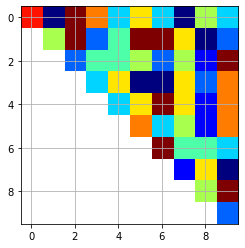

In [2]:
import numpy as NP
from matplotlib import pyplot as PLT
from matplotlib import cm as CM

A = NP.random.randint(10, 100, 100).reshape(10, 10)
mask =  NP.tri(A.shape[0], k=-1)
A = NP.ma.array(A, mask=mask) # mask out the lower triangle
fig = PLT.figure()
ax1 = fig.add_subplot(111)
cmap = CM.get_cmap('jet', 10) # jet doesn't have white color
cmap.set_bad('w') # default value is 'k'
ax1.imshow(A, interpolation="nearest", cmap=cmap)
ax1.grid(True)
PLT.show()

In [5]:
a =NP.random((10,10))
imshow(a, interpolation='nearest')

b = ones(a.shape+(4,)) # «white» matrix with alpha=1
for i in range(a.shape[0]):
    for j in range(i, a.shape[1]):
        b[i,j,3] = 0   # upper triangle, alpha = 0
imshow(b, interpolation='nearest')

TypeError: 'module' object is not callable